In [1]:
!pip install pmdarima

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [10]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv(r"C:\Users\shruthi\Desktop\cc\HCLTECH.NS.csv")

,Date,Open,High,Low,Close,Adj Close,Volume
0,13-12-2021,1166.00,1173.449951,1153.250000,1159.099976,1106.914551,2225682
1,14-12-2021,1156.00,1165.900024,1145.500000,1162.349976,1110.018188,1972685
2,15-12-2021,1158.25,1161.949951,1142.300049,1148.900024,1097.173828,1604301
3,16-12-2021,1156.00,1167.900024,1149.550049,1159.750000,1107.535156,2121810
4,17-12-2021,1172.00,1182.900024,1165.000000,1171.400024,1118.660645,6373455


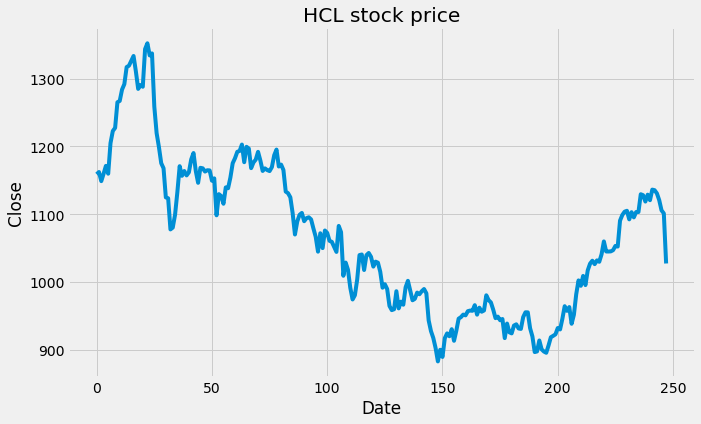

In [24]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close')
plt.plot(df['Close'])
plt.title('HCL stock price')
plt.show()


In [29]:
df_close=df['Close']

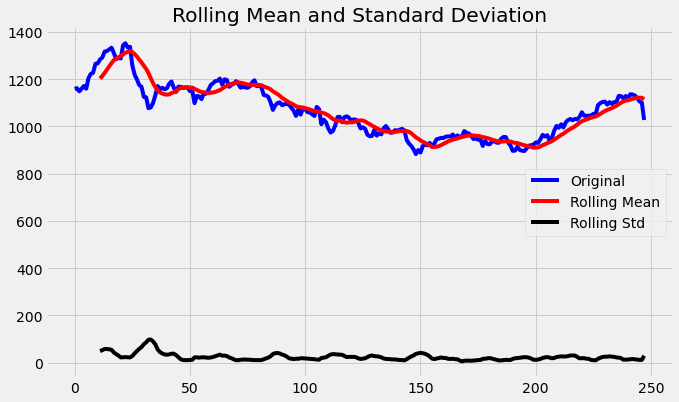

Results of dickey fuller test
Test Statistics                 -1.385483
p-value                          0.589215
No. of lags used                 0.000000
Number of observations used    247.000000
critical value (1%)             -3.457105
critical value (5%)             -2.873314
critical value (10%)            -2.573044
dtype: float64


In [30]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

No handles with labels found to put in legend.


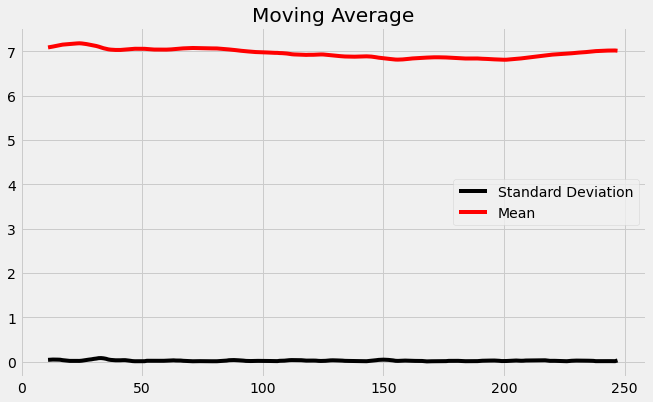

In [39]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

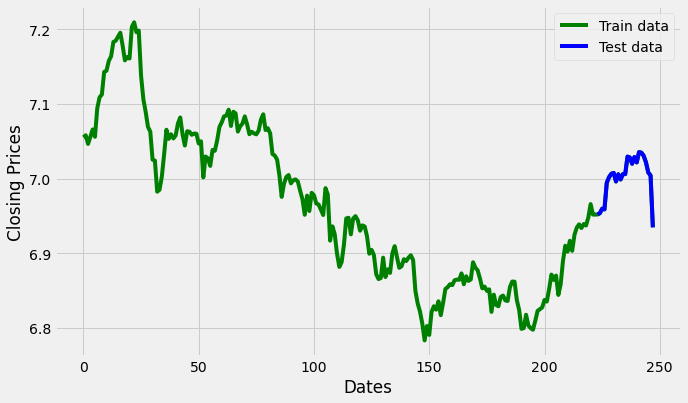

In [40]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1165.082, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1163.222, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1163.209, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1166.906, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1161.215, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.885 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  220
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 584.453
Date:                Wed, 14 Dec 2022   AIC                          -1166.906
Time:                        21:04:17   BIC                          -1163.517
Sample:                             0   HQIC                         -1165.537
                                - 220                                  

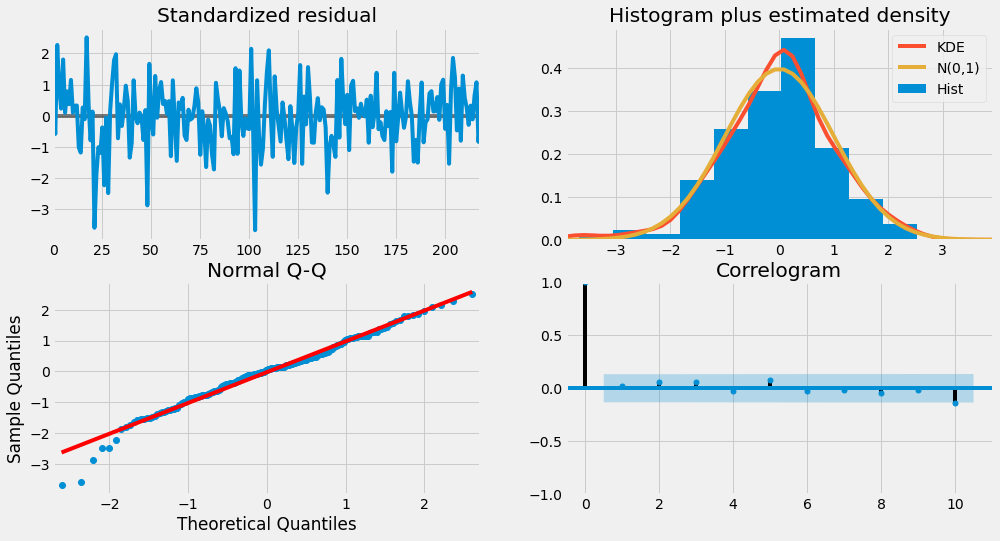

In [41]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [47]:
#Modeling
# Build Model
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2))   
fitted = model.fit()  
print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  220
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 584.675
Date:                Wed, 14 Dec 2022   AIC                          -1161.351
Time:                        21:07:29   BIC                          -1147.795
Sample:                             0   HQIC                         -1155.876
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2445      1.563     -0.156      0.876      -3.308       2.819
ma.L1          0.2681      1.562      0.172      0.864      -2.794       3.330
ma.L2          0.0458      0.067      0.689      0.4

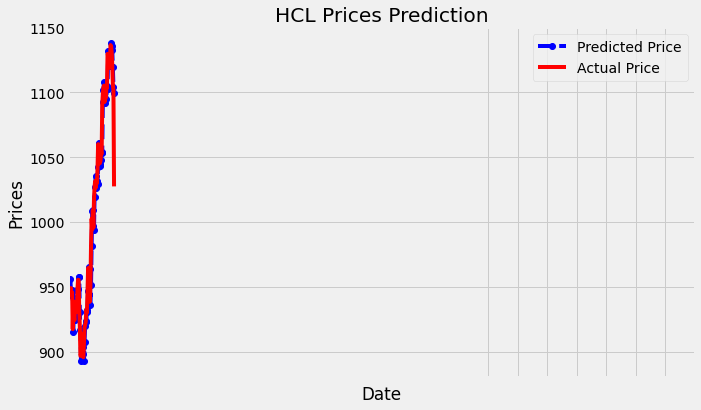

In [53]:
test_set_range = df[int(len(df)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('HCL Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.show()

In [56]:
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = sm.tsa.arima.ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
mae = mean_absolute_error(test_data,model_predictions)
rmse = math.sqrt(mean_squared_error(test_data,model_predictions))
mape = np.mean(np.abs(model_predictions - test_data)/np.abs(test_data))
print('Testing Mean Squared Error is {}'.format(MSE_error))
print('Testing Mean absolute Error is {}'.format(mae))
print('Testing root mean square Error is {}'.format(rmse))
print('Testing Mean absolute Percentage Error is {}'.format(mape))

Testing Mean Squared Error is 237.91191743113805
Testing Mean absolute Error is 10.99475566959397
Testing root mean square Error is 15.424393583902676
Testing Mean absolute Percentage Error is 0.011017422058445513


since MAPE is 0.01 forecasting model is highly accurate. 